## Imports

In [1]:
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import numpy as np
import os
from collections import defaultdict 
from nltk.corpus import stopwords

## Load Data

In [2]:
data_path = '../data/'
sen_names = pd.read_csv(os.path.join(data_path, "handles.csv"))
tweets = pd.read_csv(os.path.join(data_path, "tweets.csv"))
edges = pd.read_csv(os.path.join(data_path, "edges.csv"))

In [3]:
G = nx.DiGraph()

In [4]:
party_dict = dict(zip(sen_names["Name"], sen_names["Party"]))
for i in sen_names["Name"]:
    G.add_node(i, party = party_dict[i])
G.add_edges_from(list(zip(edges["followed"], edges["following"])))

## Graph Info (Basic)

In [5]:
print(nx.info(G))

Name: 
Type: DiGraph
Number of nodes: 100
Number of edges: 3912
Average in degree:  39.1200
Average out degree:  39.1200


C:\Users\Anurag\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:563: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
C:\Users\Anurag\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:660: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


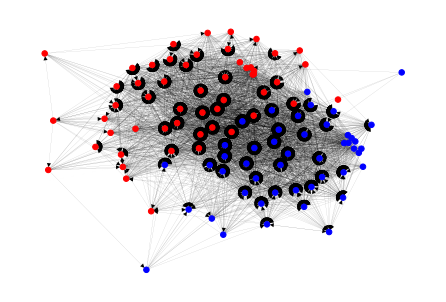

In [6]:
options = {
    'node_size': 30,
    'width': 0.05,
}
nx.draw_kamada_kawai(G, node_color = ['red' if i[1]['party'] == 'R' else 'blue' for i in G.nodes.data()], **options)

In [7]:
# Closeness centrality
closeness = nx.closeness_centrality(G)
closeness_df = pd.DataFrame(list(zip(closeness.keys(), closeness.values())))

In [8]:
print("The highest closeness centrality:", max(closeness.values()))
print("The most important senator (highest centrality): WV Joe Manchin III")

The highest closeness centrality: 0.9604960496049605
The most important senator (highest centrality): WV Joe Manchin III


# Interestingly, High Centrality seems to correspond to moderates in the Senate

For example, Joe Manchin, a West Virginian Democrat who is currently blocking the $15 minimum wage, has the highest centrality. Meanwhile, of the two independents, Susan Collins, who is moderate in comparison to Bernie Sanders, has the highest centrality

In [9]:
closeness_df
closeness_df.columns = ["Senator Name", "Centrality"]
closeness_df["Party"] = closeness_df["Senator Name"].apply(lambda x: party_dict[x])
closeness_df["Centrality"] = pd.to_numeric(closeness_df["Centrality"])
closeness_df.groupby("Party").idxmax()

,Centrality
Party,
D,92.0
I,40.0
R,35.0


In [10]:
closeness_df[closeness_df["Party"] == "I"]

,Senator Name,Centrality,Party
40,ME Susan M. Collins,0.88191,I
91,VT Bernard Sanders,0.58794,I


In [11]:
voting_data = pd.read_csv(os.path.join(data_path, "voting.csv"))
voting_data = voting_data.merge(sen_names, left_on = "Senator Name", right_on = "Name")[voting_data.columns.tolist() + ["Party"]]
voting_data.head()

,Senator Name,Decision,Bill,Party
0,TN Lamar Alexander,Yea,0,R
1,TN Lamar Alexander,Yea,1,R
2,TN Lamar Alexander,Yea,2,R
3,TN Lamar Alexander,Yea,3,R
4,TN Lamar Alexander,Nay,4,R


In [12]:
dec_dict = dict(zip(list(set(voting_data["Decision"])), list(range(len(voting_data["Decision"])))))
voting_data["Decision"] = voting_data["Decision"].apply(lambda x : dec_dict[x])
voting_piv = pd.pivot_table(voting_data, index='Senator Name', columns='Bill')
voting_piv.head()

Decision                             ...                 \
Bill                       0  1  2  3  4  5  6  7  8  9   ... 69 70 71 72 73   
Senator Name                                              ...                  
AK Dan Sullivan             2  2  2  2  3  3  3  3  2  2  ...  2  2  2  2  2   
AK Lisa Murkowski           2  2  2  2  3  3  2  3  2  2  ...  2  2  2  2  2   
AL Doug Jones               2  2  2  2  2  2  2  3  2  2  ...  2  2  3  3  3   
AL Richard C. Shelby        2  2  2  2  3  3  3  3  2  2  ...  2  2  2  2  2   
AR John Boozman             2  2  2  2  3  3  3  3  2  2  ...  2  2  2  2  2   

                                     
Bill                 74 75 76 77 78  
Senator Name                         
AK Dan Sullivan       2  2  2  2  2  
AK Lisa Murkowski     2  2  2  2  2  
AL Doug Jones         3  3  3  3  3  
AL Richard C. Shelby  2  2  2  2  2  
AR John Boozman       2  2  2  2  2  

[5 rows x 79 columns]

In [13]:
#Which way did most of each party vote for a certain bill?
def mode(series):
    return series.value_counts().keys()[0]
party_mode = pd.pivot_table(voting_data, index=['Bill', 'Party'], values = "Decision", aggfunc = mode)
party_mode.head()

Decision
Bill Party          
0    D             2
     I             2
     R             2
1    D             2
     I             2

In [14]:
voting_data["Line"] = pd.Series(zip(voting_data["Decision"], voting_data["Bill"], voting_data["Party"])).apply(lambda x : party_mode.loc[(x[1],x[2])])
voting_data["Broken Line"] = voting_data["Line"] == voting_data["Decision"]
line_breakers = 79 - voting_data.groupby("Senator Name")[["Broken Line"]].sum()

In [15]:
line_breakers.reset_index().merge(closeness_df, on = "Senator Name").corr()

,Broken Line,Centrality
Broken Line,1.000000,0.105865
Centrality,0.105865,1.000000


In [16]:
between = nx.betweenness_centrality(G)
between_df = pd.DataFrame(list(zip(between.keys(), between.values())))
between_df.columns = ["Senator Name", "Between"]
between_df["Party"] = between_df["Senator Name"].apply(lambda x: party_dict[x])
between_df["Between"] = pd.to_numeric(between_df["Between"])
between_df.groupby("Party").max()

,Senator Name,Between
Party,,
D,WV Joe Manchin III,0.012582
I,VT Bernard Sanders,0.012721
R,WY Michael B. Enzi,0.061043


In [17]:
line_breakers.reset_index().merge(between_df, on = "Senator Name").corr()

,Broken Line,Between
Broken Line,1.000000,0.032979
Between,0.032979,1.000000


In [18]:
# new = tweets.groupby("Senator Name").agg({"Tweets": sum})

In [19]:
# def pop_words(tweets):
#     #generate top 1000 popular words
#     tweets = tweets.groupby("Senator Name").agg({"Tweets": sum})
#     total_words = defaultdict(int)
#     stopWords = set(stopwords.words('english'))
#     total_tweet = tweets["Tweets"].values
#     for i in total_tweet:
#         row_words = i.split()
#         for j in row_words:
#             j = j.lower()
#             if j not in stopWords:
#                 total_words[j] += 1
#     total_words = {key: val for key, val in sorted(total_words.items(), key = lambda ele: ele[1], reverse = True)}
#     total_keys = total_words.keys()
#     top_1000 = []
#     count = 0
#     for z in total_keys:
#         top_1000.append(z)
#         count += 1
#         if count == 1000:
#             break;
#     id_1000 = dict(zip(top_1000, range(1000)))
    
#     #create features
#     feature = []
#     for i in total_tweet:
#         feat = [0]*1000
#         row_words = i.split()
#         for j in row_words:
#             if j in top_1000:
#                 feat[id_1000[j]] += 1
#         feature.append(feat)
#     return feature

In [20]:
# feature = pop_words(tweets)